# Data EDA - Customized Image Generation

**Nguyễn Khang Hy (2352662)**

EDA cho dự án Style Transfer với Stable Diffusion + LoRA.


## 1. Setup Environment


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import Counter
import cv2
import sys

In [2]:
# Clone repository từ GitHub
!git clone https://github.com/HyIsNoob/customized-image-generation.git

Cloning into 'customized-image-generation'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 133 (delta 61), reused 111 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (133/133), 202.74 KiB | 6.99 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [3]:
# Import libraries

sys.path.append('/kaggle/working/customized-image-generation')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Dataset Paths


In [4]:
# Kaggle dataset paths
COCO_TRAIN_DIR = Path('/kaggle/input/coco-2017-dataset/coco2017/train2017')
COCO_VAL_DIR = Path('/kaggle/input/coco-2017-dataset/coco2017/val2017')
WIKIART_DIR = Path('/kaggle/input/wikiart')

print(f"COCO train directory exists: {COCO_TRAIN_DIR.exists()}")
print(f"COCO val directory exists: {COCO_VAL_DIR.exists()}")
print(f"WikiArt directory exists: {WIKIART_DIR.exists()}")


COCO train directory exists: True
COCO val directory exists: True
WikiArt directory exists: True


## 3. COCO Dataset Analysis


In [5]:
# Get all COCO images
coco_train_images = list(COCO_TRAIN_DIR.glob('*.jpg'))
coco_val_images = list(COCO_VAL_DIR.glob('*.jpg')) if COCO_VAL_DIR.exists() else []

print(f"Total COCO train images: {len(coco_train_images)}")
print(f"Total COCO val images: {len(coco_val_images)}")
print(f"Total COCO images: {len(coco_train_images) + len(coco_val_images)}")

coco_images = coco_train_images  


Total COCO train images: 118287
Total COCO val images: 5000
Total COCO images: 123287


In [6]:
# Analyze image sizes
def get_image_size(image_path):
    try:
        img = Image.open(image_path)
        return img.size
    except:
        return None

sample_size = min(1000, len(coco_images))
sample_images = np.random.choice(coco_images, sample_size, replace=False)

sizes = []
for img_path in sample_images:
    size = get_image_size(img_path)
    if size:
        sizes.append(size)

widths = [s[0] for s in sizes]
heights = [s[1] for s in sizes]
aspect_ratios = [w/h for w, h in zip(widths, heights)]


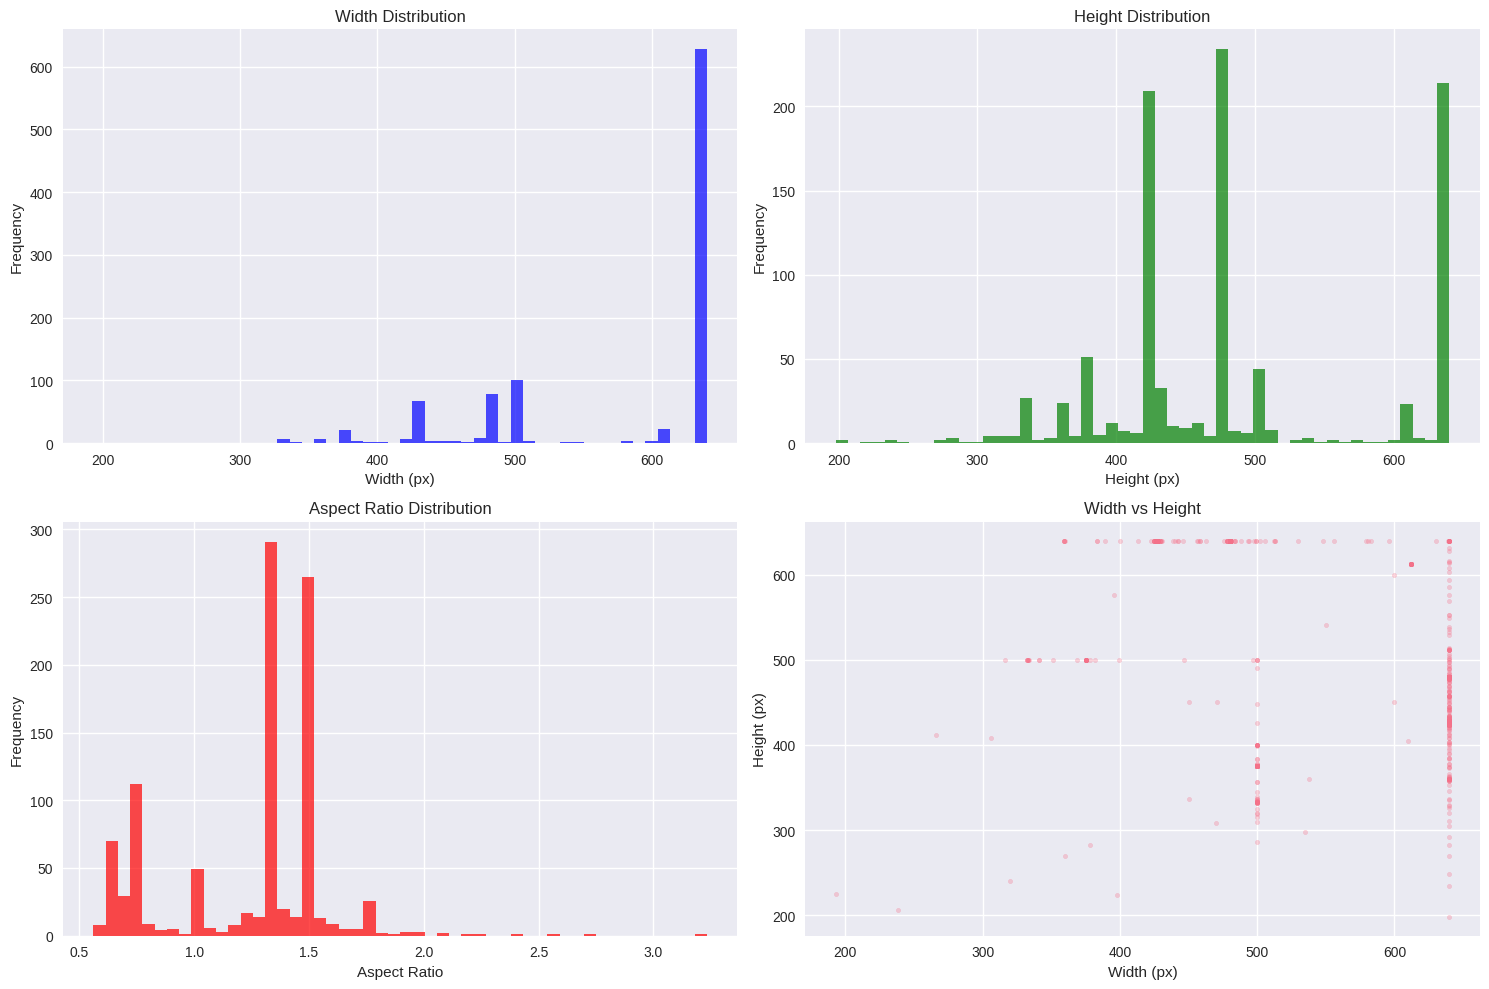

Mean width: 576px
Mean height: 486px
Mean aspect ratio: 1.25


In [7]:
# Visualize COCO statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(widths, bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('Width Distribution')
axes[0, 0].set_xlabel('Width (px)')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(heights, bins=50, alpha=0.7, color='green')
axes[0, 1].set_title('Height Distribution')
axes[0, 1].set_xlabel('Height (px)')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(aspect_ratios, bins=50, alpha=0.7, color='red')
axes[1, 0].set_title('Aspect Ratio Distribution')
axes[1, 0].set_xlabel('Aspect Ratio')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].scatter(widths, heights, alpha=0.3, s=10)
axes[1, 1].set_title('Width vs Height')
axes[1, 1].set_xlabel('Width (px)')
axes[1, 1].set_ylabel('Height (px)')

plt.tight_layout()
plt.savefig('/kaggle/working/coco_stats.png', dpi=150)
plt.show()

print(f"Mean width: {np.mean(widths):.0f}px")
print(f"Mean height: {np.mean(heights):.0f}px")
print(f"Mean aspect ratio: {np.mean(aspect_ratios):.2f}")


### 3.1. Detailed Statistics


In [8]:
# Detailed statistics
print("=== COCO Dataset Statistics ===")
print(f"Total train images: {len(coco_train_images):,}")
print(f"Total val images: {len(coco_val_images):,}")
print(f"\nImage Size Statistics (sample of {len(sizes)} images):")
print(f"  Width:  min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.0f}, median={np.median(widths):.0f}")
print(f"  Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.0f}, median={np.median(heights):.0f}")
print(f"  Aspect Ratio: min={min(aspect_ratios):.2f}, max={max(aspect_ratios):.2f}, mean={np.mean(aspect_ratios):.2f}, median={np.median(aspect_ratios):.2f}")

# Create summary DataFrame
coco_stats_df = pd.DataFrame({
    'width': widths,
    'height': heights,
    'aspect_ratio': aspect_ratios
})
print("\nDetailed Statistics:")
print(coco_stats_df.describe())


=== COCO Dataset Statistics ===
Total train images: 118,287
Total val images: 5,000

Image Size Statistics (sample of 1000 images):
  Width:  min=193, max=640, mean=576, median=640
  Height: min=198, max=640, mean=486, median=480
  Aspect Ratio: min=0.56, max=3.23, mean=1.25, median=1.33

Detailed Statistics:
             width       height  aspect_ratio
count  1000.000000  1000.000000   1000.000000
mean    575.986000   485.889000      1.246204
std      92.386368    98.240307      0.344593
min     193.000000   198.000000      0.560937
25%     500.000000   426.000000      1.000000
50%     640.000000   480.000000      1.333333
75%     640.000000   553.000000      1.498829
max     640.000000   640.000000      3.232323


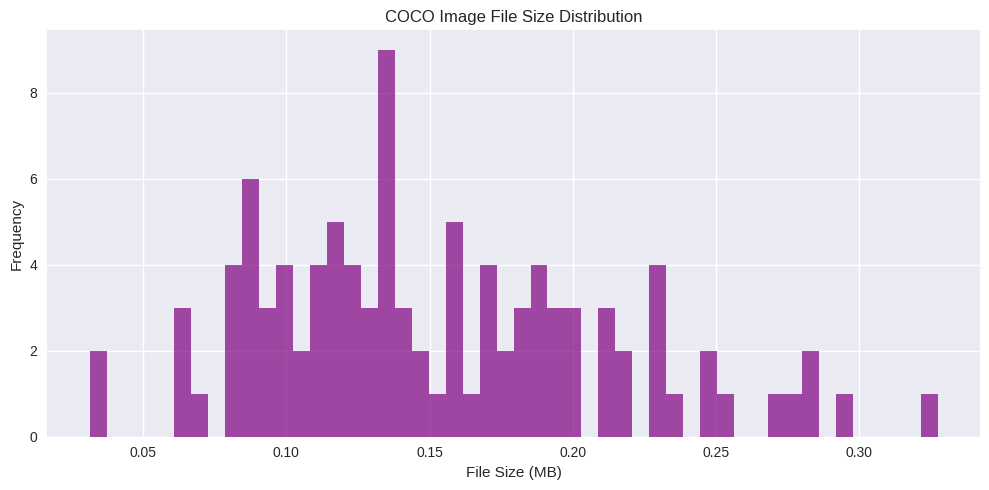

Mean file size: 0.15 MB
Median file size: 0.14 MB


In [9]:
# Analyze file sizes
file_sizes = []
for img_path in sample_images[:100]:
    try:
        size = os.path.getsize(img_path) / (1024 * 1024)  # MB
        file_sizes.append(size)
    except:
        pass

if file_sizes:
    plt.figure(figsize=(10, 5))
    plt.hist(file_sizes, bins=50, alpha=0.7, color='purple')
    plt.xlabel('File Size (MB)')
    plt.ylabel('Frequency')
    plt.title('COCO Image File Size Distribution')
    plt.tight_layout()
    plt.savefig('/kaggle/working/coco_file_sizes.png', dpi=150)
    plt.show()
    
    print(f"Mean file size: {np.mean(file_sizes):.2f} MB")
    print(f"Median file size: {np.median(file_sizes):.2f} MB")

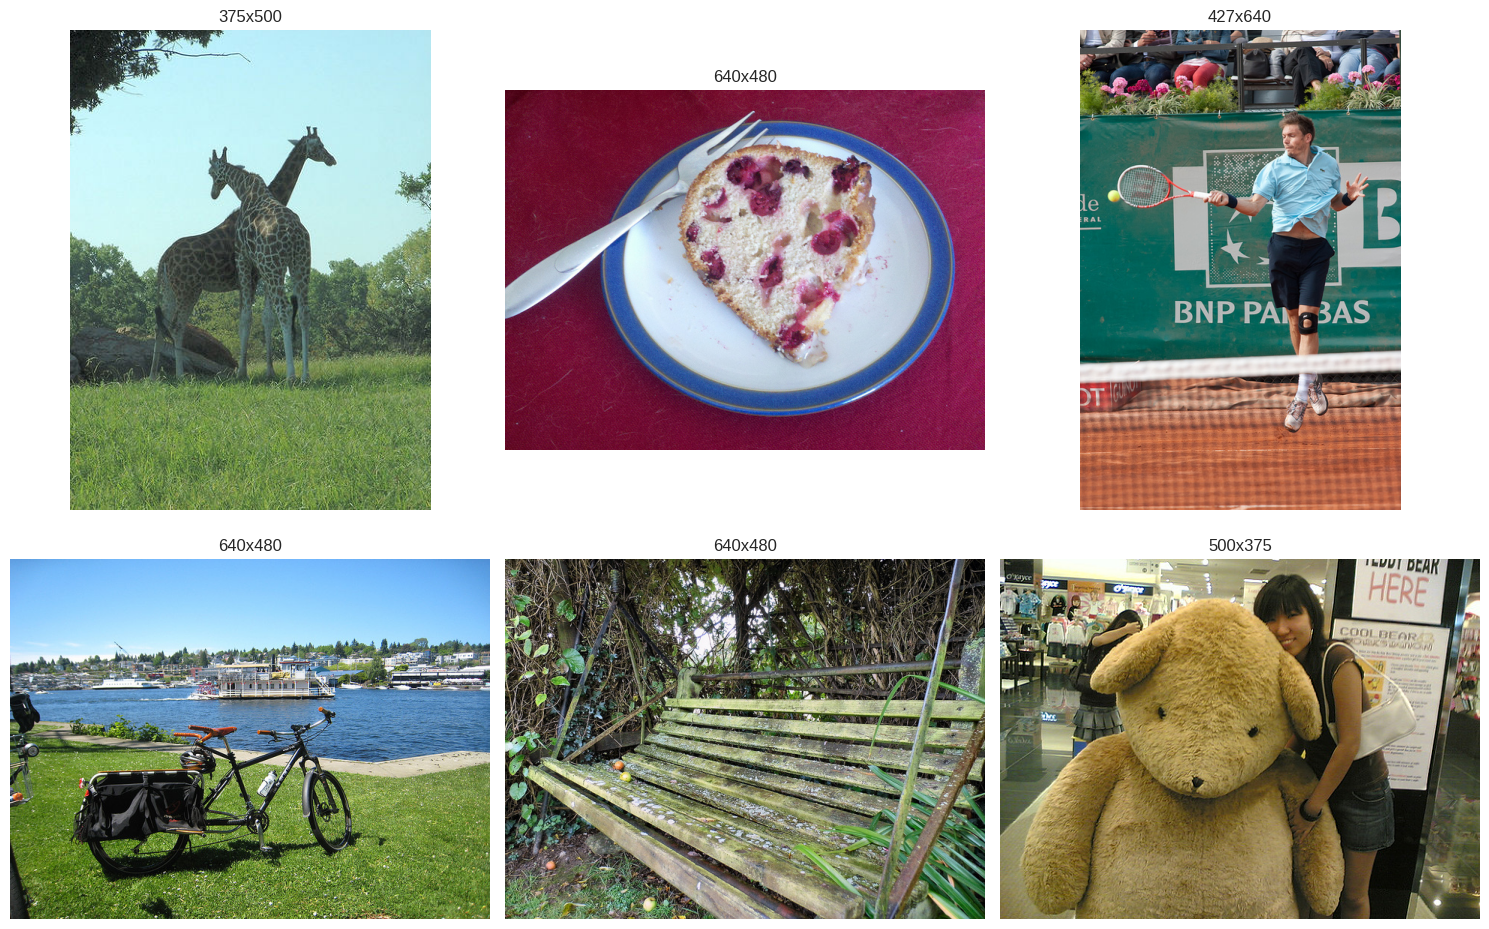

In [10]:
# Display sample COCO images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sample_imgs = np.random.choice(coco_images, 6, replace=False)

for ax, img_path in zip(axes.flat, sample_imgs):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(f"{img.size[0]}x{img.size[1]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/coco_samples.png', dpi=150)
plt.show()


## 4. WikiArt Dataset Analysis


In [11]:
# Explore WikiArt structure
wikiart_subdirs = [d for d in WIKIART_DIR.iterdir() if d.is_dir()]
print(f"Number of style directories: {len(wikiart_subdirs)}")
print(f"Style directories: {[d.name for d in wikiart_subdirs[:10]]}")


Number of style directories: 27
Style directories: ['Pop_Art', 'Minimalism', 'Color_Field_Painting', 'Mannerism_Late_Renaissance', 'Symbolism', 'Impressionism', 'Contemporary_Realism', 'High_Renaissance', 'Fauvism', 'Rococo']


In [12]:
# Count images per style
style_counts = {}
for style_dir in wikiart_subdirs:
    images = list(style_dir.glob('*.jpg')) + list(style_dir.glob('*.png'))
    style_counts[style_dir.name] = len(images)

style_df = pd.DataFrame(list(style_counts.items()), columns=['Style', 'Count'])
style_df = style_df.sort_values('Count', ascending=False)

print(style_df.head(20))


                         Style  Count
5                Impressionism  13060
26                     Realism  10733
21                 Romanticism   7019
20               Expressionism   6736
24          Post_Impressionism   6450
4                    Symbolism   4528
25          Art_Nouveau_Modern   4334
18                     Baroque   4240
16      Abstract_Expressionism   2782
22        Northern_Renaissance   2552
11       Naive_Art_Primitivism   2405
13                      Cubism   2235
9                       Rococo   2089
2         Color_Field_Painting   1615
0                      Pop_Art   1483
10           Early_Renaissance   1391
7             High_Renaissance   1343
1                   Minimalism   1337
3   Mannerism_Late_Renaissance   1279
23                     Ukiyo_e   1167


### 4.1. WikiArt Image Size Analysis


WikiArt mean width: 1688px
WikiArt mean height: 1621px


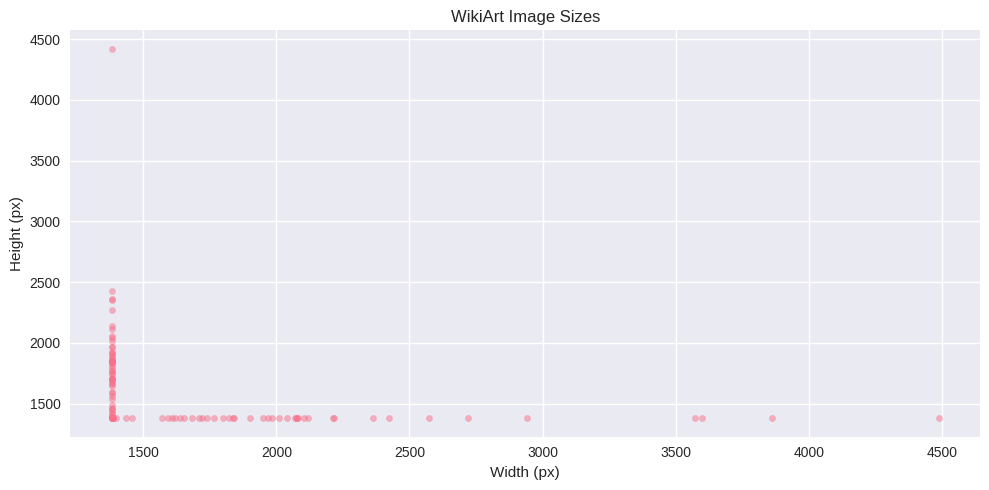

In [13]:
# Analyze WikiArt image sizes
wikiart_sizes = []
for style_dir in wikiart_subdirs[:5]:
    images = list(style_dir.glob('*.jpg'))[:20]
    for img_path in images:
        size = get_image_size(img_path)
        if size:
            wikiart_sizes.append(size)

if wikiart_sizes:
    wikiart_widths = [s[0] for s in wikiart_sizes]
    wikiart_heights = [s[1] for s in wikiart_sizes]
    
    print(f"WikiArt mean width: {np.mean(wikiart_widths):.0f}px")
    print(f"WikiArt mean height: {np.mean(wikiart_heights):.0f}px")
    
    plt.figure(figsize=(10, 5))
    plt.scatter(wikiart_widths, wikiart_heights, alpha=0.5, s=20)
    plt.xlabel('Width (px)')
    plt.ylabel('Height (px)')
    plt.title('WikiArt Image Sizes')
    plt.tight_layout()
    plt.savefig('/kaggle/working/wikiart_sizes.png', dpi=150)
    plt.show()


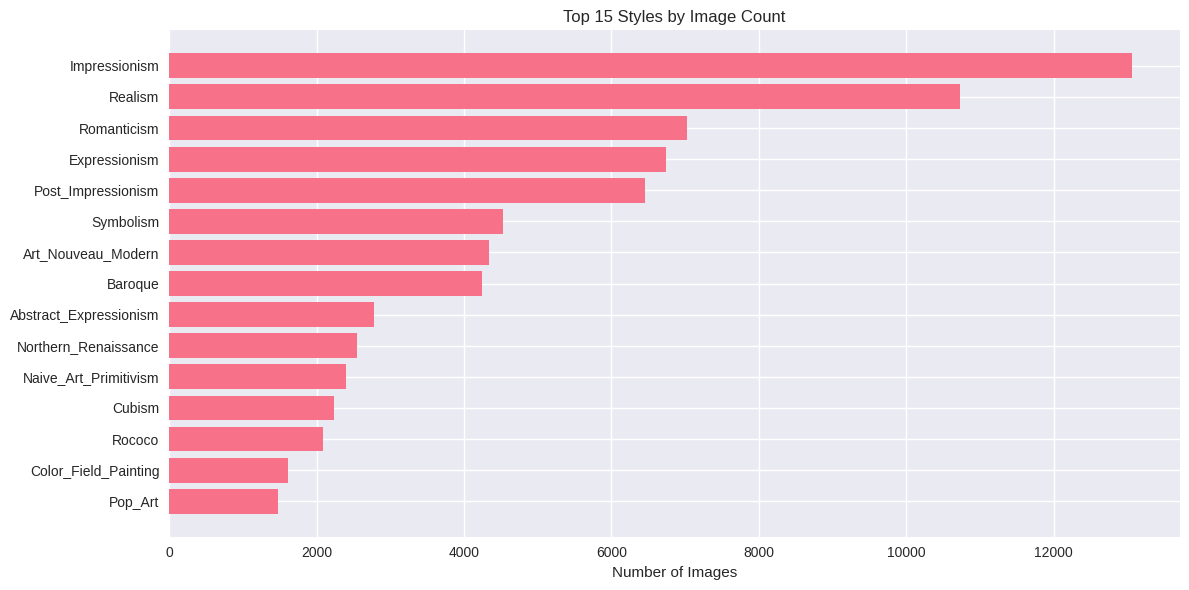

In [14]:
# Visualize style distribution
top_styles = style_df.head(15)
plt.figure(figsize=(12, 6))
plt.barh(top_styles['Style'], top_styles['Count'])
plt.xlabel('Number of Images')
plt.title('Top 15 Styles by Image Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/kaggle/working/wikiart_style_distribution.png', dpi=150)
plt.show()


In [15]:
eligible_styles = style_df[style_df['Count'] >= 50]
if len(eligible_styles) >= 5:
    selected_styles = eligible_styles.tail(5).sort_values('Count', ascending=False)
else:
    selected_styles = eligible_styles.sort_values('Count', ascending=False)

print("Selected styles for training:")
print(selected_styles)
print(f"\nTotal selected: {len(selected_styles)} styles")

Selected styles for training:
                   Style  Count
6   Contemporary_Realism    481
17           New_Realism    314
14      Synthetic_Cubism    216
19     Analytical_Cubism    110
15       Action_painting     98

Total selected: 5 styles


### 4.2. Color Analysis


In [16]:
# Analyze color distribution (HSV) - Optional, có thể skip nếu chạy lâu
def get_color_stats(image_path, n_samples=1000):
    try:
        img = Image.open(image_path).resize((256, 256))
        img_array = np.array(img)
        hsv = cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)
        
        pixels = hsv.reshape(-1, 3)
        sample_pixels = pixels[np.random.choice(len(pixels), min(n_samples, len(pixels)), replace=False)]
        
        return {
            'hue_mean': np.mean(sample_pixels[:, 0]),
            'saturation_mean': np.mean(sample_pixels[:, 1]),
            'value_mean': np.mean(sample_pixels[:, 2])
        }
    except:
        return None

coco_sample = np.random.choice(coco_images, 20, replace=False)
coco_colors = []
for img_path in coco_sample:
    stats = get_color_stats(img_path)
    if stats:
        coco_colors.append(stats)

if coco_colors:
    coco_color_df = pd.DataFrame(coco_colors)
    print("COCO Color Statistics:")
    print(coco_color_df.describe())


COCO Color Statistics:
         hue_mean  saturation_mean  value_mean
count   20.000000        20.000000   20.000000
mean    59.164500        79.524450  121.840950
std     27.821926        39.563689   28.638712
min     13.783000        29.254000   46.596000
25%     44.981250        51.965750  110.512750
50%     50.788000        68.163500  126.332000
75%     80.813250       111.196250  139.621500
max    110.020000       150.368000  179.005000


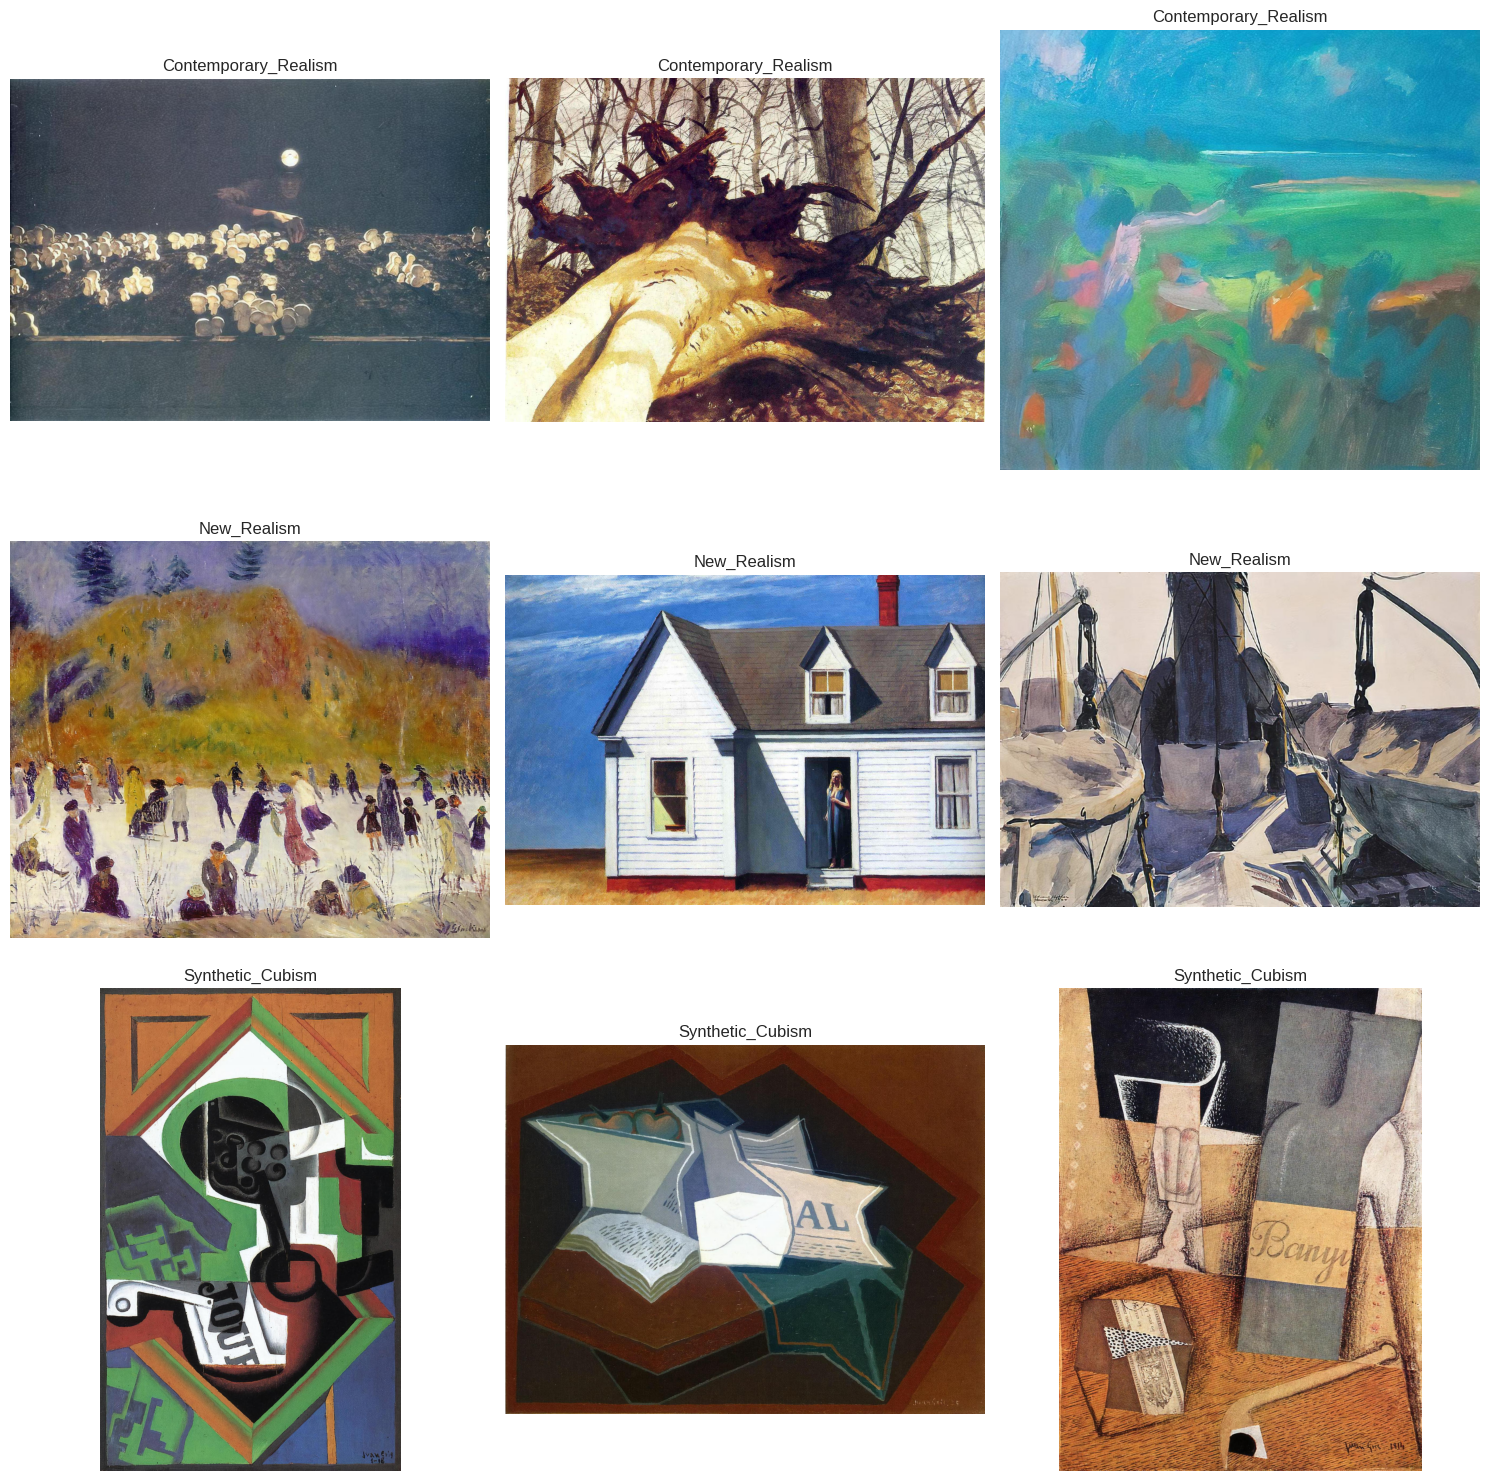

In [17]:
# Display sample WikiArt images from different styles
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
selected_style_dirs = [WIKIART_DIR / style for style in selected_styles['Style'].head(3).tolist()]

for row, style_dir in enumerate(selected_style_dirs):
    images = list(style_dir.glob('*.jpg'))[:3]
    for col, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{style_dir.name}")
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/wikiart_samples.png', dpi=150)
plt.show()


### 4.3. Style Selection Recommendations


In [18]:
# Final style selection with detailed info
print("=== Recommended Styles for Training ===")
print(f"\nSelected {len(selected_styles)} styles:")
for idx, row in selected_styles.iterrows():
    style_name = row['Style']
    count = row['Count']
    style_path = WIKIART_DIR / style_name
    print(f"\n{idx+1}. {style_name}")
    print(f"   - Number of images: {count}")
    print(f"   - Path: {style_path}")
    
    # Check sample images
    sample_imgs = list(style_path.glob('*.jpg'))[:3]
    if sample_imgs:
        print(f"   - Sample files: {[img.name for img in sample_imgs]}")

# Save selected styles to CSV for Minh Quốc
selected_styles.to_csv('/kaggle/working/selected_styles.csv', index=False)
print(f"\nSelected styles saved to selected_styles.csv")


=== Recommended Styles for Training ===

Selected 5 styles:

7. Contemporary_Realism
   - Number of images: 481
   - Path: /kaggle/input/wikiart/Contemporary_Realism
   - Sample files: ['jamie-wyeth_mushroom-picker-1963.jpg', 'jamie-wyeth_fallen-1975.jpg', 'john-miller_late-summer-landscape.jpg']

18. New_Realism
   - Number of images: 314
   - Path: /kaggle/input/wikiart/New_Realism
   - Sample files: ['william-james-glackens_skating-in-central-park-1910.jpg', 'edward-hopper_not_detected_235611.jpg', 'edward-hopper_funell-of-trawler.jpg']

15. Synthetic_Cubism
   - Number of images: 216
   - Path: /kaggle/input/wikiart/Synthetic_Cubism
   - Sample files: ['juan-gris_pipe-and-fruit-dish-with-grapes-1918.jpg', 'juan-gris_compotier-carafe-and-open-book.jpg', 'juan-gris_the-bottle-of-banyuls-1914-1.jpg']

20. Analytical_Cubism
   - Number of images: 110
   - Path: /kaggle/input/wikiart/Analytical_Cubism
   - Sample files: ['pablo-picasso_clarinetist.jpg', 'georges-braque_still-life-with-a

## 5. Summary Report


In [19]:
# Generate summary report
min_images = selected_styles['Count'].min()
max_images = selected_styles['Count'].max()
image_range = f"{min_images}-{max_images}" if min_images != max_images else str(min_images)

report = f"""
# Data EDA Report

## COCO Dataset
- Train images: {len(coco_train_images)} (dùng cho training)
- Val images: {len(coco_val_images)} (dùng cho validation/testing)
- Mean size: {np.mean(widths):.0f}x{np.mean(heights):.0f}px
- Mean aspect ratio: {np.mean(aspect_ratios):.2f}

## WikiArt Dataset
- Total styles: {len(wikiart_subdirs)}
- Selected styles for training: {len(selected_styles)}
- Styles: {', '.join(selected_styles['Style'].head(5).tolist())}
- Image count per style: {image_range} images

## Recommendations
- Resize all images to 512x512 for training
- Use train2017 ({len(coco_train_images)} images) cho training LoRA
- Use val2017 ({len(coco_val_images)} images) cho validation/testing sau khi train
- Use selected styles with {image_range} images each (total: {selected_styles['Count'].sum()} style images)
- Consider data augmentation for style images if needed
"""

print(report)

# Save report
with open('/kaggle/working/eda_report.md', 'w') as f:
    f.write(report)


# Data EDA Report

## COCO Dataset
- Train images: 118287 (dùng cho training)
- Val images: 5000 (dùng cho validation/testing)
- Mean size: 576x486px
- Mean aspect ratio: 1.25

## WikiArt Dataset
- Total styles: 27
- Selected styles for training: 5
- Styles: Contemporary_Realism, New_Realism, Synthetic_Cubism, Analytical_Cubism, Action_painting
- Image count per style: 98-481 images

## Recommendations
- Resize all images to 512x512 for training
- Use train2017 (118287 images) cho training LoRA
- Use val2017 (5000 images) cho validation/testing sau khi train
- Use selected styles with 98-481 images each (total: 1219 style images)
- Consider data augmentation for style images if needed

